#### References
1. https://www.youtube.com/live/QpR4QEv5Urk?si=vp2-7Q5a_fwmJ7nw
2. https://drive.google.com/file/d/1YuvEFydZZynnzBpEgW8NvRF9vWKYwW2K/view?usp=sharing

#### Mounting Google Drive

In [ ]:
from google.colab import drive


drive.mount("/content/gdrive")

%cd /content/gdrive/MyDrive/colab-docs/advanced-ml/

Mounted at /content/gdrive
/content/gdrive/MyDrive/colab-docs/advanced-ml


#### Importing Python Packages

In [ ]:
import os
import shutil
import random

import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder, MNIST
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Grayscale,
    Normalize,
    Resize,
    ToTensor,
)
from torchvision.utils import make_grid, save_image

#### Set Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

#### Creating Folders

In [ ]:
data_dir = "data"
if not os.path.exists(data_dir):
  os.makedirs(data_dir)

models_dir = "models"
if not os.path.exists(models_dir):
  os.makedirs(models_dir)

In [ ]:
temp_dir = "temp"
if os.path.exists(temp_dir):
  shutil.rmtree(temp_dir)

os.makedirs(temp_dir)

In [ ]:
discriminator_file_path = os.path.join(models_dir, "D.pkl")
generator_file_path = os.path.join(models_dir, "G.pkl")
classifier_file_path = os.path.join(models_dir, "C.pkl")

#### Creating Utility Functions

In [ ]:
def denormalize(image, mean, std):
  return image * std + mean


def show_image(image):
  fig, ax = plt.subplots(figsize=(1, 1))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(image.to("cpu"), cmap='gray')
  plt.show()


def show_images(images, mean, std, nmax):
  fig, ax = plt.subplots(figsize=(4, 4))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(denormalize(images.detach()[:nmax], mean, std), nrow=8).permute(1, 2, 0))
  plt.show()


def show_batch(dl, mean, std, nth_batch=0, nmax=64):
  for i, (images, _) in enumerate(dl):
    if i == nth_batch:
      show_images(images, mean, std, nmax)
      break

#### Preparing Data

In [ ]:
mean, std = 0.5, 0.5

In [ ]:
batch_size = 30
stats = (mean,), (std,)

In [ ]:
composed_transform = Compose([
    ToTensor(), Normalize(*stats)
])

In [ ]:
train_ds = MNIST(
    root=data_dir,
    train=True,
    transform=composed_transform,
    download=True,
)
test_ds = MNIST(
    root=data_dir,
    train=False,
    transform=composed_transform,
    download=False,
)

In [ ]:
train_dl = DataLoader(
    dataset=train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)
test_dl = DataLoader(
    dataset=test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

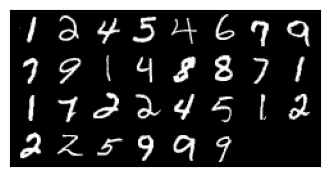

In [ ]:
show_batch(train_dl, mean, std, nth_batch=10)

shape: torch.Size([30, 1, 28, 28])
label: 7


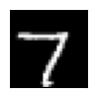

image_size: 28
input_size: 784


In [ ]:
for images, labels in train_dl:
  print(f"shape: {images.shape}")
  image_size = images.shape[2]
  input_size = image_size ** 2
  print(f"label: {labels[0]}")
  show_image(denormalize(images[0][0], mean, std))
  break

print(f"image_size: {image_size}")
print(f"input_size: {input_size}")

In [ ]:
images[0][0].shape

torch.Size([28, 28])

#### A. MODELS CREATION

### Creating Discriminator

In [ ]:
discriminator = nn.Sequential(
    nn.Linear(input_size, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 100),
    nn.LeakyReLU(0.2),
    nn.Linear(100, 1),
    nn.Sigmoid(),
)

In [ ]:
# discriminator = nn.Sequential(
#     nn.Conv2d(
#         in_channels=1,
#         out_channels=36,
#         kernel_size=5,
#         stride=1,
#         padding=2,
#     ),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Conv2d(36, 32, 5, 1, 2),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Flatten(),
#     nn.Linear(32 * 7 * 7, 1),
#     nn.Sigmoid(),
# )

In [ ]:
discriminator.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=100, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=100, out_features=1, bias=True)
  (5): Sigmoid()
)

In [ ]:
discriminator_lr = 0.0002

In [ ]:
discriminator_criterion = nn.BCELoss()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=discriminator_lr)

### Creating Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self, latent_size, image_size):
    super(Generator, self).__init__()
    self.linr1 = nn.Sequential(
        nn.Linear(latent_size, 256),
        nn.ReLU(),
        nn.Linear(256, image_size ** 2),
        nn.Tanh(),
    )
    self.image_size = image_size

  def forward(self, x):
    x = self.linr1(x)
    # x = x.view(x.size(0), 1, self.image_size, self.image_size)
    return x

In [ ]:
# class Generator(nn.Module):
#   def __init__(self, latent_size, image_size):
#     super(Generator, self).__init__()
#     self.linr1 = nn.Sequential(
#         nn.Linear(latent_size, 256),
#         nn.ReLU(),
#         nn.Linear(256, 64 * (image_size // 4) * (image_size // 4)),
#         nn.ReLU(),
#     )
#     self.conv1 = nn.Sequential(
#         nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
#         nn.ReLU(),
#         nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
#         nn.Tanh(),
#     )
#     self.image_size = image_size
#
#   def forward(self, x):
#     x = self.linr1(x)
#     x = x.view(x.size(0), 64, (self.image_size // 4), (self.image_size // 4))
#     x = self.conv1(x)
#     return x

In [ ]:
latent_size = 100

In [ ]:
generator = Generator(latent_size, image_size)

In [ ]:
generator.to(device)

Generator(
  (linr1): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Tanh()
  )
)

In [ ]:
generated_images = generator(torch.randn(2, latent_size).to(device))
print(f"shape: {generated_images.shape}")
# generated_images[0]

shape: torch.Size([2, 784])


In [ ]:
generated_images = denormalize(generated_images.reshape((-1, 28, 28)).detach(), mean, std)
print(f"shape: {generated_images.shape}")
# generated_images[0]

shape: torch.Size([2, 28, 28])


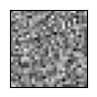

In [ ]:
show_image(generated_images[0])

In [ ]:
generator_lr = 0.0002

In [ ]:
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=generator_lr)

#### Creating Discriminator Training Function

In [ ]:
def train_discriminator(real_images):
  cur_batch_size = len(real_images)

  x_real = real_images.to(device)
  y_real = torch.ones(cur_batch_size, 1).to(device)

  y_hat = discriminator(x_real)
  discriminator_j_real = discriminator_criterion(y_hat, y_real)

  score_real = y_hat

  z = torch.randn(cur_batch_size, latent_size).to(device)
  fake_images = generator(z)

  x_fake = fake_images
  y_fake = torch.zeros(cur_batch_size, 1).to(device)

  y_hat = discriminator(x_fake)
  discriminator_j_fake = discriminator_criterion(y_hat, y_fake)

  score_fake = y_hat

  discriminator_j = discriminator_j_real + discriminator_j_fake

  discriminator_optimizer.zero_grad()
  generator_optimizer.zero_grad()

  discriminator_j.backward()

  discriminator_optimizer.step()

  return discriminator_j.item(), score_real, score_fake

#### Creating Generator Training Function

In [ ]:
def train_generator(cur_batch_size):
  z = torch.randn(cur_batch_size, latent_size).to(device)
  fake_images = generator(z)

  x_fake = fake_images
  y_real = torch.ones(cur_batch_size, 1).to(device)

  y_hat = discriminator(x_fake)
  generator_j = discriminator_criterion(y_hat, y_real)

  discriminator_optimizer.zero_grad()
  generator_optimizer.zero_grad()

  generator_j.backward()

  generator_optimizer.step()

  return generator_j.item(), fake_images

#### Training the Models

In [ ]:
num_epochs = 300
total_step = len(train_dl)

In [ ]:
%%time

discriminator_js, generator_js, scores_real, scores_fake = [], [], [], []

for epoch in range(num_epochs):
  d_js, g_js, scores_r, scores_f = [], [], [], []
  for i, (real_images, _) in enumerate(train_dl):
    cur_batch_size = len(real_images)

    real_images = real_images.reshape(cur_batch_size, -1).to(device)
    # real_images = real_images.to(device)

    discriminator_j, score_real, score_fake = train_discriminator(real_images)
    generator_j, fake_images = train_generator(cur_batch_size)

    with torch.no_grad():
      d_js.append(discriminator_j)
      g_js.append(generator_j)

      scores_r.append(score_real.mean().item())
      scores_f.append(score_fake.mean().item())

      if (i + 1) % 200 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Step [{str(i + 1).zfill(4)}/{total_step}], "
            f"Discriminator Loss: {discriminator_j:.2f}, "
            f"Generator Loss: {generator_j:.2f}, "
            f"D(x): {score_real.mean().item():.2f}, "
            f"D(G(z)): {score_fake.mean().item():.2f}"
        )

  with torch.no_grad():
    discriminator_js.append(np.mean(d_js))
    generator_js.append(np.mean(g_js))

    scores_real.append(np.mean(scores_r))
    scores_fake.append(np.mean(scores_f))

    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    print(f"Saving the generated images at the end of epoch number: {epoch + 1}\n")
    save_image(denormalize(fake_images, mean, std), os.path.join(temp_dir, f"{epoch + 1}.png"), nrow=10)

Epoch [1/300], Step [0200/2000], Discriminator Loss: 0.05, Generator Loss: 3.81, D(x): 0.99, D(G(z)): 0.04
Epoch [1/300], Step [0400/2000], Discriminator Loss: 0.83, Generator Loss: 1.13, D(x): 0.76, D(G(z)): 0.40
Epoch [1/300], Step [0600/2000], Discriminator Loss: 0.06, Generator Loss: 3.72, D(x): 0.98, D(G(z)): 0.05
Epoch [1/300], Step [0800/2000], Discriminator Loss: 0.24, Generator Loss: 2.76, D(x): 0.90, D(G(z)): 0.10
Epoch [1/300], Step [1000/2000], Discriminator Loss: 1.25, Generator Loss: 1.17, D(x): 0.67, D(G(z)): 0.45
Epoch [1/300], Step [1200/2000], Discriminator Loss: 0.62, Generator Loss: 2.66, D(x): 0.83, D(G(z)): 0.25
Epoch [1/300], Step [1400/2000], Discriminator Loss: 0.08, Generator Loss: 4.31, D(x): 0.96, D(G(z)): 0.03
Epoch [1/300], Step [1600/2000], Discriminator Loss: 0.43, Generator Loss: 2.23, D(x): 0.81, D(G(z)): 0.15
Epoch [1/300], Step [1800/2000], Discriminator Loss: 0.84, Generator Loss: 1.75, D(x): 0.69, D(G(z)): 0.21
Epoch [1/300], Step [2000/2000], Disc

#### Visualizations

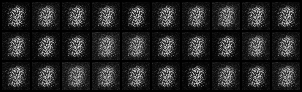

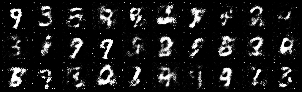

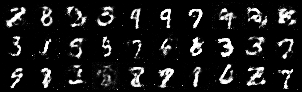

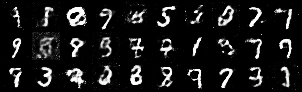

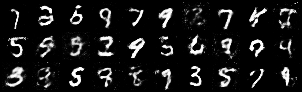

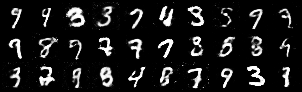

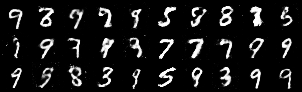

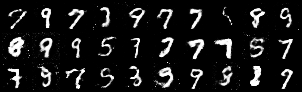

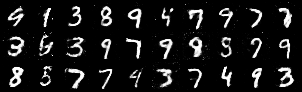

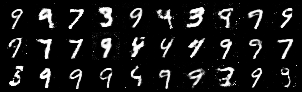

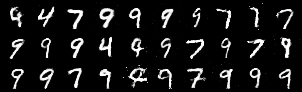

In [ ]:
for epoch in range(num_epochs):
  if (epoch == 0) or ((epoch + 1) % (num_epochs // 10) == 0):
    display(Image(os.path.join(temp_dir, f"{epoch + 1}.png")))
    print()

In [ ]:
# x = np.array(list(range(1, (num_epochs * total_step) + 1))) / total_step

In [ ]:
x = np.array(list(range(1, num_epochs + 1)))

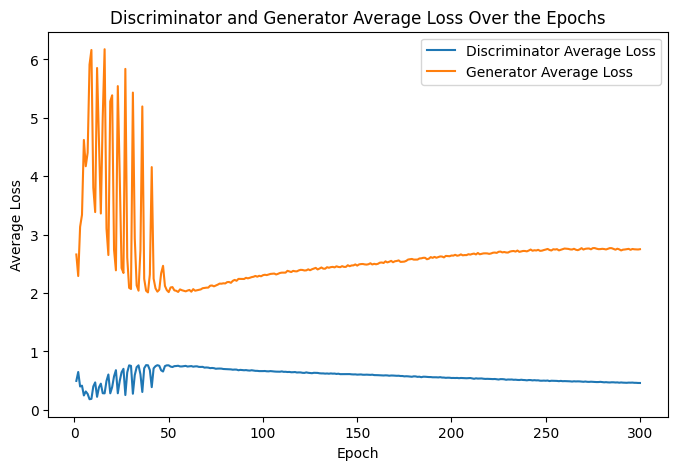

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(x, discriminator_js, label="Discriminator Average Loss", linestyle="-")
plt.plot(x, generator_js, label="Generator Average Loss", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Discriminator and Generator Average Loss Over the Epochs")
plt.legend()
plt.grid(False)
plt.show()

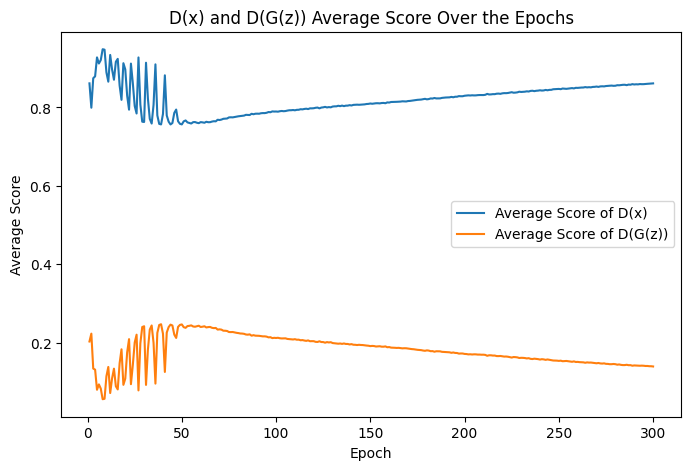

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(x, scores_real, label="Average Score of D(x)", linestyle="-")
plt.plot(x, scores_fake, label="Average Score of D(G(z))", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Average Score")
plt.title("D(x) and D(G(z)) Average Score Over the Epochs")
plt.legend()
plt.grid(False)
plt.show()

#### Storing the Discriminator & Generator

In [ ]:
with open(discriminator_file_path, "wb") as f:
  pickle.dump(discriminator, f)

with open(generator_file_path, "wb") as f:
  pickle.dump(generator, f)

#### Classifier

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(
            in_channels=1,
            out_channels=36,
            kernel_size=5,
            stride=1,
            padding=2,
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(36, 32, 5, 1, 2),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )
    self.out = nn.Linear(32 * 7 * 7, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.size(0), -1)
    output = self.out(x)
    return output

In [ ]:
classifier = CNN()

In [ ]:
classifier.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(36, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [ ]:
classifier_lr = 0.01

In [ ]:
classifier_criterion = nn.CrossEntropyLoss()
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=classifier_lr)

In [ ]:
num_epochs = 3
total_step = len(train_dl)

In [ ]:
classifier.train()
classifier_js = []

for epoch in range(num_epochs):
  c_js = []
  for i, (images, labels) in enumerate(train_dl):
    x = images.to(device)
    y = labels.to(device)

    y_hat = classifier(x)
    classifier_j = classifier_criterion(y_hat, y)

    classifier_optimizer.zero_grad()

    classifier_j.backward()

    classifier_optimizer.step()

    with torch.no_grad():
      c_js.append(classifier_j.item())

      if (i + 1) % 200 == 0:
        y_pred = torch.max(y_hat, 1)[1].data.squeeze()
        accuracy_score = (y == y_pred).sum().item() / float(y.size(0))

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Step [{str(i + 1).zfill(4)}/{total_step}], "
            f"Classifier Training Loss: {classifier_j.item():.2f}, "
            f"Classifier Training Accuracy Score: {accuracy_score:.2f}"
        )

  with torch.no_grad():
    classifier_js.append(np.mean(c_js))

Epoch [1/3], Step [0200/2000], Classifier Training Loss: 0.01, Classifier Training Accuracy Score: 1.00
Epoch [1/3], Step [0400/2000], Classifier Training Loss: 0.16, Classifier Training Accuracy Score: 0.97
Epoch [1/3], Step [0600/2000], Classifier Training Loss: 0.06, Classifier Training Accuracy Score: 0.97
Epoch [1/3], Step [0800/2000], Classifier Training Loss: 0.03, Classifier Training Accuracy Score: 0.97
Epoch [1/3], Step [1000/2000], Classifier Training Loss: 0.58, Classifier Training Accuracy Score: 0.90
Epoch [1/3], Step [1200/2000], Classifier Training Loss: 0.08, Classifier Training Accuracy Score: 0.97
Epoch [1/3], Step [1400/2000], Classifier Training Loss: 0.09, Classifier Training Accuracy Score: 0.97
Epoch [1/3], Step [1600/2000], Classifier Training Loss: 0.03, Classifier Training Accuracy Score: 1.00
Epoch [1/3], Step [1800/2000], Classifier Training Loss: 0.09, Classifier Training Accuracy Score: 0.93
Epoch [1/3], Step [2000/2000], Classifier Training Loss: 0.14, C

In [ ]:
x = np.array(list(range(1, num_epochs + 1)))

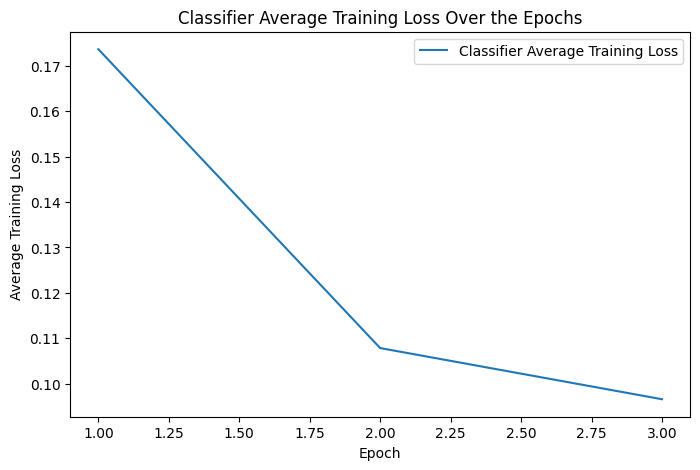

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(x, classifier_js, label="Classifier Average Training Loss", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.title("Classifier Average Training Loss Over the Epochs")
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
classifier.eval()

with torch.no_grad():
  n_correct = 0
  n_samples = 0

  for images, labels in test_dl:
    x = images.to(device)
    y = labels.to(device)

    y_hat = classifier(x)
    y_pred = torch.max(y_hat, 1)[1].data.squeeze()

    n_samples += y.size(0)
    n_correct += (y == y_pred).sum().item()

  accuracy = n_correct / n_samples
  print(f"Classifier Test Accuracy Score: {accuracy:.2f}")

Classifier Test Accuracy Score: 0.97


In [ ]:
x, y = test_ds[5]
x.shape

torch.Size([1, 28, 28])

In [ ]:
x = x.reshape(1, 1, 28, 28)
x.shape

torch.Size([1, 1, 28, 28])

In [ ]:
y

1

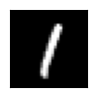

In [ ]:
show_image(denormalize(x[0][0], mean, std))

In [ ]:
torch.max(classifier(x), 1)[1].data.squeeze().item()

1

#### Storing the Classifier

In [ ]:
with open(classifier_file_path, "wb") as f:
  pickle.dump(classifier, f)

#### B. EXPERIMEMT

#### Load Trained Models

In [ ]:
with open(discriminator_file_path, "rb") as f:
  discriminator = pickle.load(f)
  discriminator.to(device)

with open(generator_file_path, "rb") as f:
  generator = pickle.load(f)
  generator.to(device)

with open(classifier_file_path, "rb") as f:
  classifier = pickle.load(f)
  classifier.to(device)

#### Store Images

In [ ]:
real_images_dir = "images/mnist/real"
if not os.path.exists(real_images_dir):
  os.makedirs(real_images_dir)

fake_images_dir = "images/mnist/fake"
if not os.path.exists(fake_images_dir):
  os.makedirs(fake_images_dir)

1. Store some real images

In [ ]:
count = 10
for i, (real_image, _) in enumerate(test_ds):
  if count == i:
    break

  file_name = str(i + 1).zfill(3)

  save_image(denormalize(real_image, mean, std), os.path.join(real_images_dir, f"{file_name}.png"))

Image(os.path.join(real_images_dir, "001.png"))

2. Store some fake images

In [ ]:
count = 100

z = torch.randn(count, latent_size).to(device)
fake_images = generator(z)
fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
save_image(denormalize(fake_images, mean, std), os.path.join(fake_images_dir, "combined-100.png"), nrow=10)

for i, (fake_image, z_i) in enumerate(zip(fake_images, z)):
  if count == i:
    break

  file_name = str(i + 1).zfill(3)

  save_image(denormalize(fake_image, mean, std), os.path.join(fake_images_dir, f"{file_name}.png"))

  with open(os.path.join(fake_images_dir, f"{file_name}.txt"), "w") as f:
    f.write(str(z_i.tolist()))

Image(os.path.join(fake_images_dir, "001.png"))

#### Creating S0 & S1 Datasets

In [ ]:
batch_size = 100

In [ ]:
random_idxs = random.sample(range(len(test_ds)), batch_size)
S0 = [test_ds[i] for i in random_idxs]

In [ ]:
composed_transform = Compose([
    Grayscale(num_output_channels=1),
    ToTensor(),
    Normalize(*stats)
])

In [ ]:
s1_dir = "images/mnist/fake/Fake_Digits"
S1 = ImageFolder(root=s1_dir, transform=composed_transform)

In [ ]:
for idx in range(len(S1)):
  img_path, label = S1.imgs[idx]
  folder_name = os.path.basename(os.path.dirname(img_path))
  S1.samples[idx] = (img_path, int(folder_name))

#### Creating S0 & S1 Data Loaders

In [ ]:
s0_dl = DataLoader(
    dataset=S0,
    batch_size=batch_size,
    shuffle=False,
)
s1_dl = DataLoader(
    dataset=S1,
    batch_size=batch_size,
    shuffle=False,
)

#### Calculating Classification Errors

In [ ]:
classifier.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(36, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [ ]:
def get_classification_error(dl):
  with torch.no_grad():
    n_correct = 0
    n_samples = 0

    for images, labels in dl:
      x = images.to(device)
      y = labels.to(device)

      y_hat = classifier(x)
      y_pred = torch.max(y_hat, 1)[1].data.squeeze()

      n_samples += y.size(0)
      n_correct += (y == y_pred).sum().item()

    accuracy = n_correct / n_samples
    return 1 - accuracy

In [ ]:
print(f"Classification Error for S0: {get_classification_error(s0_dl):.2f}")

Classification Error for S0: 0.02


In [ ]:
print(f"Classification Error for S1: {get_classification_error(s1_dl):.2f}")

Classification Error for S1: 0.12
